In [57]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import kagglehub
import os

In [219]:
# Getting the dataset
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
files = os.listdir(path)
csv_file = [file for file in files if file.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)
# path = "AB_NYC_2019.csv"
df = pd.read_csv(csv_path)
#print(df)

In [223]:
#1. Examine the data, there may be some anomalies in the data, and you will have to clean the data
#   before you move forward to other tasks. Explain what you did to clean the data. (10 Points)

'''
For data cleaning, I removed all the rows with any null values, duplicate values, and outliers
'''
#Drop rows with any null values
df_removed_null = df.dropna()
#Remove all duplicates
df_before= df_removed_null.drop_duplicates()
#Remove outliers
numeric_cols = df_before.select_dtypes(include=['float64', 'int64']).columns

#Calculate Q1, Q3, and IQR for each column
Q1 = df_before[numeric_cols].quantile(0.25)
Q3 = df_before[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
#Calculate lower and upper bounds for each column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Remove the outliers from df
df_cleaned = df_before[~((df_before[numeric_cols] < lower_bound) | (df_before[numeric_cols] > upper_bound)).any(axis=1)]
print("For data cleaning, I removed all the rows with any null values, duplicate values, and outliers\n")
# print(df_cleaned.head())
print(df_cleaned.info())
print()
print(df_cleaned.describe())
print()

For data cleaning, I removed all the rows with any null values, duplicate values, and outliers

<class 'pandas.core.frame.DataFrame'>
Index: 22756 entries, 1 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              22756 non-null  int64  
 1   name                            22756 non-null  object 
 2   host_id                         22756 non-null  int64  
 3   host_name                       22756 non-null  object 
 4   neighbourhood_group             22756 non-null  object 
 5   neighbourhood                   22756 non-null  object 
 6   latitude                        22756 non-null  float64
 7   longitude                       22756 non-null  float64
 8   room_type                       22756 non-null  object 
 9   price                           22756 non-null  int64  
 10  minimum_nights                  22756 non-null  int64  
 11  nu

Top 5 Cheapest Neighborhoods:
neighbourhood
Tremont           52.666667
Kingsbridge       53.090909
Bronxdale         53.461538
Parkchester       56.444444
Morris Heights    61.250000
Name: price, dtype: float64

Top 5 Most Expensive Neighborhoods:
neighbourhood
Greenwich Village    181.280952
Flatiron District    183.031250
NoHo                 189.814815
West Village         192.233596
Tribeca              197.408163
Name: price, dtype: float64



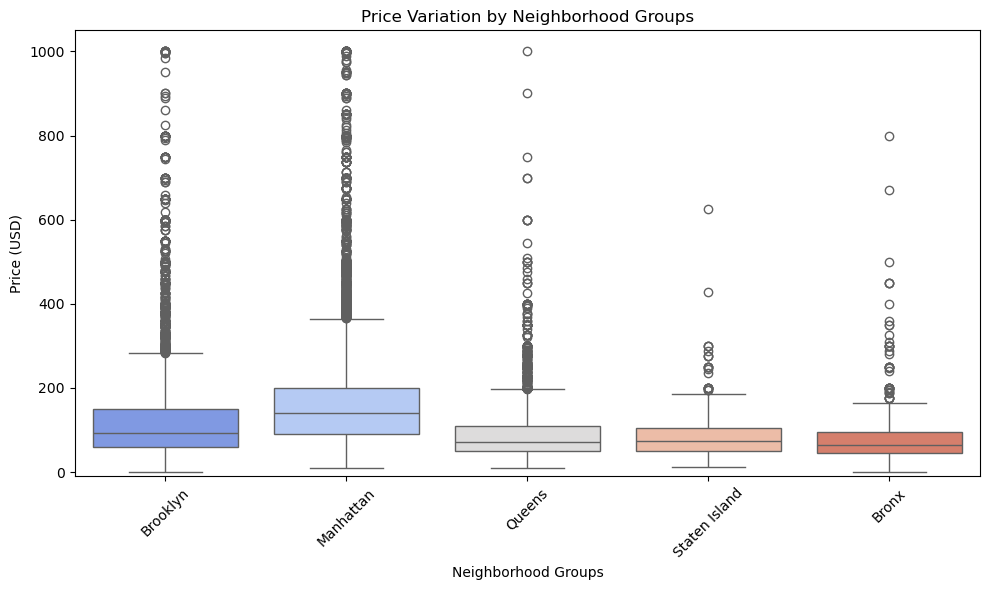

In [251]:
# 2. Examine how the prices of the Airbnb change with the change in the neighborhood.
#    a. Find Top 5 and Bottom 5 neighborhoods based on the price of the Airbnb in that neighborhood
#       (select only neighborhoods with more than 5 listings). (10 Points)
#    b. Analyze the price variation between different neighborhood groups and plot these trends. (5 Points)

# a. Find Top 5 and Bottom 5 neighborhoods based on the price of the Airbnb in that neighborhood

#Count the number of listings in each neighborhood
neighborhood_count = df_cleaned['neighbourhood'].value_counts()

#Filter neighborhoods with more than 5 listings
valid_neighborhoods = neighborhood_count[neighborhood_count > 5].index

#Calculate the average price for each valid neighborhood
neighborhood_avg_price = df_cleaned[df_cleaned['neighbourhood'].isin(valid_neighborhoods)].groupby('neighbourhood')['price'].mean()

#Sort the neighborhoods by average price
sorted_neighborhoods_by_price = neighborhood_avg_price.sort_values()

#Get the top 5 and bottom 5 neighborhoods
top_5_cheapest_neighborhoods = sorted_neighborhoods_by_price.head(5)
top_5_expensive_neighborhoods = sorted_neighborhoods_by_price.tail(5)

print("Top 5 Cheapest Neighborhoods:")
print(top_5_cheapest_neighborhoods)
print()
print("Top 5 Most Expensive Neighborhoods:")
print(top_5_expensive_neighborhoods)
print()

#b. Analyze, the price variation between different neighborhood group, and plot these trends.

#Filter the data to only include rows where the price is less than or equal to 1000
df_filtered = df_before[df_before['price'] <= 1000]

#Boxplot for price distribution by neighborhood group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x="neighbourhood_group", y="price", hue="neighbourhood_group", palette="coolwarm")
plt.ylim(-10, 1050)
plt.xlabel("Neighborhood Groups")
plt.ylabel("Price (USD)")
plt.title("Price Variation by Neighborhood Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

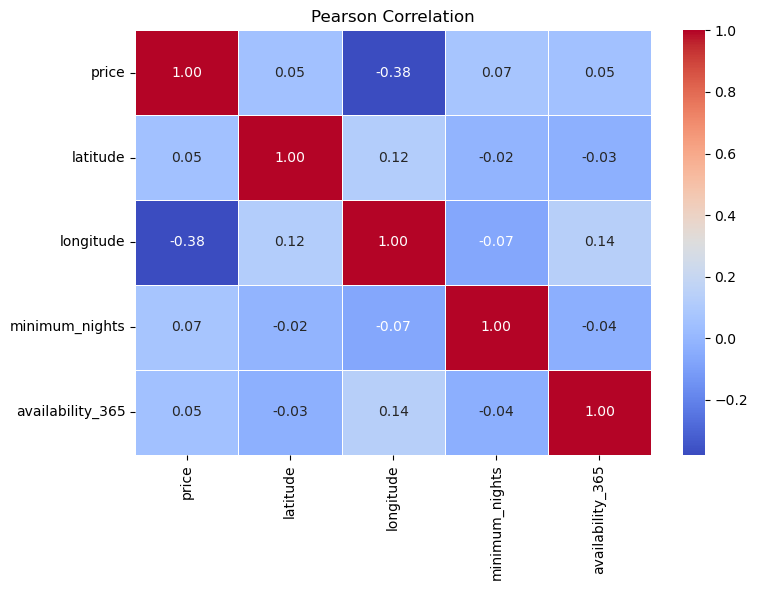


Top 3 Most Positive Correlations:
price           price             1.0
latitude        latitude          1.0
minimum_nights  minimum_nights    1.0
dtype: float64

Top 3 Most Negative Correlations:
longitude       price       -0.378023
price           longitude   -0.378023
minimum_nights  longitude   -0.066832
dtype: float64


In [229]:
# 3. Select a set of the most interesting features. Do a pairwise Pearson correlation analysis on all pairs
#    of these variables. Show the result with a heat map and find out most positive and negative
#    correlations. (5 points)

#Select a subset of numerical features that you find interesting for correlation analysis
interesting_features = ['price', 'latitude', 'longitude', 'minimum_nights', 'availability_365']

#Compute the Pearson correlation matrix for these features
correlation_matrix = df_cleaned[interesting_features].corr(method='pearson')

#Display the correlation matrix
#print("Pearson Correlation Matrix:")
#print(correlation_matrix)

#Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Pearson Correlation")
plt.tight_layout()
plt.show()

#Identify the most positive and negative correlations
positive_corr = correlation_matrix.unstack().sort_values(ascending=False)
negative_corr = correlation_matrix.unstack().sort_values(ascending=True)

#Display the top 3 positive and negative correlations
print("\nTop 3 Most Positive Correlations:")
print(positive_corr.head(3))
print("\nTop 3 Most Negative Correlations:")
print(negative_corr.head(3))

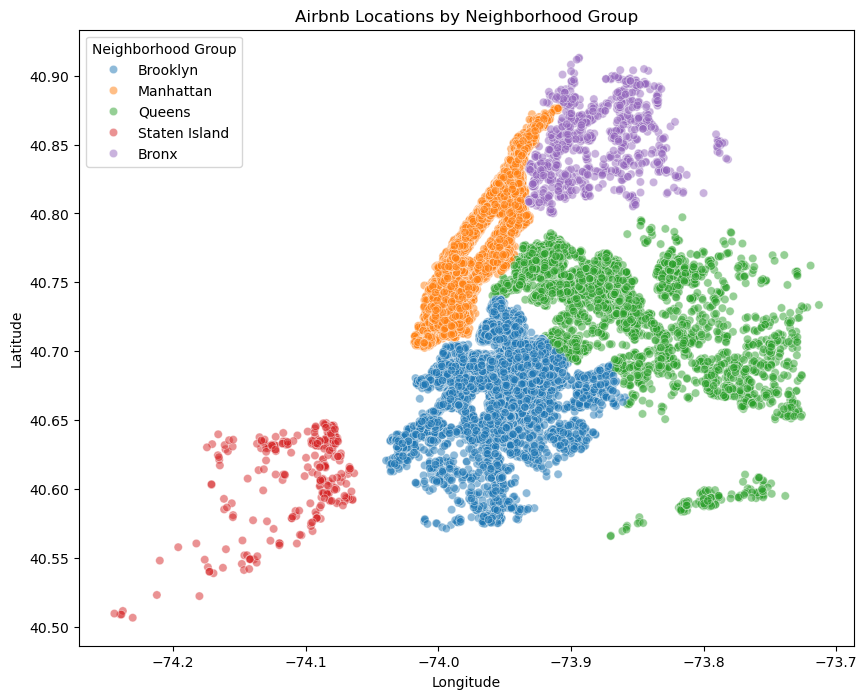

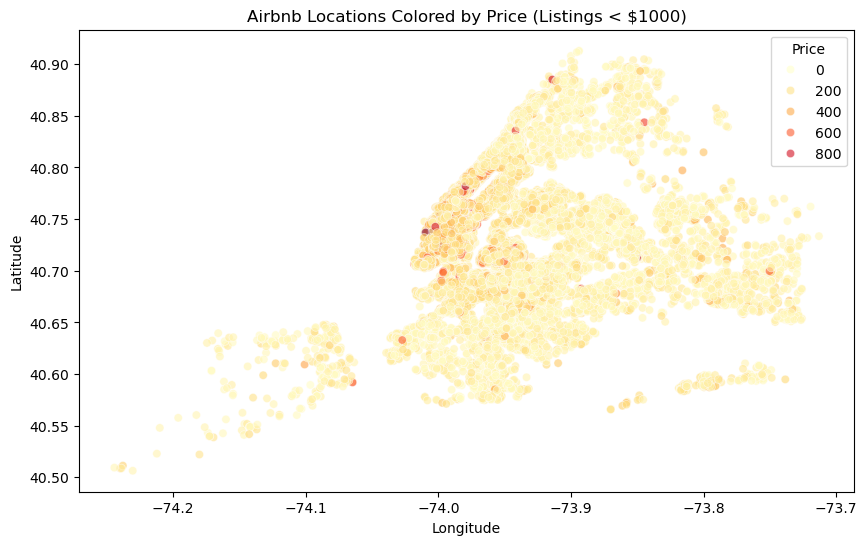

In [62]:
# 4. The Latitude and Longitude of all the Airbnb listings are provided in the dataset.
#   a. Plot a scatter plot based on these coordinates, where the points represent the location of an
#      Airbnb, and the points are color coded based on the neighborhood group feature. (5 Points)
#   b. Now again, plot a scatter plot based on these coordinates, where the points represent the
#      location of an Airbnb, and the points are color coded based on the price of the particular Airbnb,
#      where price of the listing is less than 1000. Looking at the graph can you tell which
#      neighborhood group is the most expensive. (5 Points)

#a. Plot a scatter plot based on these coordinates, where the points represent the location of an
#   Airbnb, and the points are color coded based on the neighborhood group feature. (5 Points)

#Scatter plot for Airbnb locations colored by neighborhood group
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_before, 
    x="longitude", 
    y="latitude", 
    hue="neighbourhood_group", 
    palette="tab10", 
    alpha=0.5
)

# Add title and labels
plt.title("Airbnb Locations by Neighborhood Group")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Neighborhood Group")
plt.show()

#b. Now again, plot a scatter plot based on these coordinates, where the points represent the
#   location of an Airbnb, and the points are color coded based on the price of the particular Airbnb,
#   where price of the listing is less than 1000. Looking at the graph can you tell which
#   neighborhood group is the most expensive. (5 Points)

#Filter the dataset for listings where the price is below 1000
df_filtered_price = df_before[df_before['price'] < 1000]

#Scatter plot for Airbnb locations, colored by price
plt.figure(figsize=(10, 6))

#Create scatter plot
sns.scatterplot(
    data=df_filtered_price, 
    x="longitude", 
    y="latitude", 
    hue="price", 
    palette="YlOrRd",
    alpha=0.6
)
plt.title("Airbnb Locations Colored by Price (Listings < $1000)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Price", loc="upper right")
plt.show()

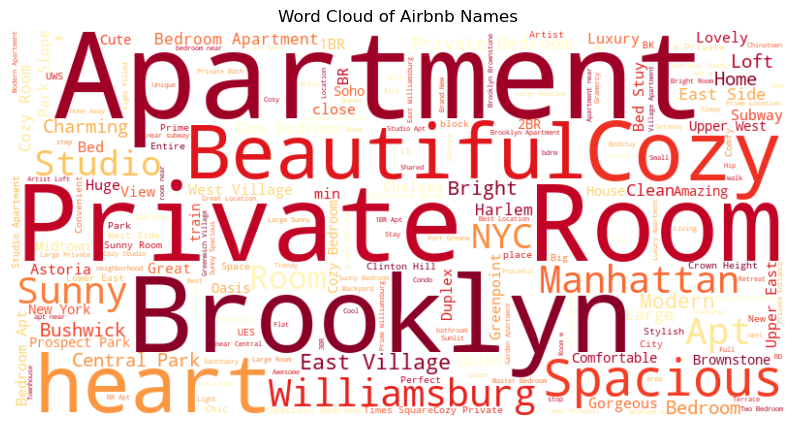

In [249]:
#5. Word clouds are useful tool to explore the text data. Extract the words from the name of the Airbnb
# and generate a word cloud. (5 Points)

text = " ".join(df_cleaned['name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='YlOrRd').generate(text)

#Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Airbnb Names")
plt.show()

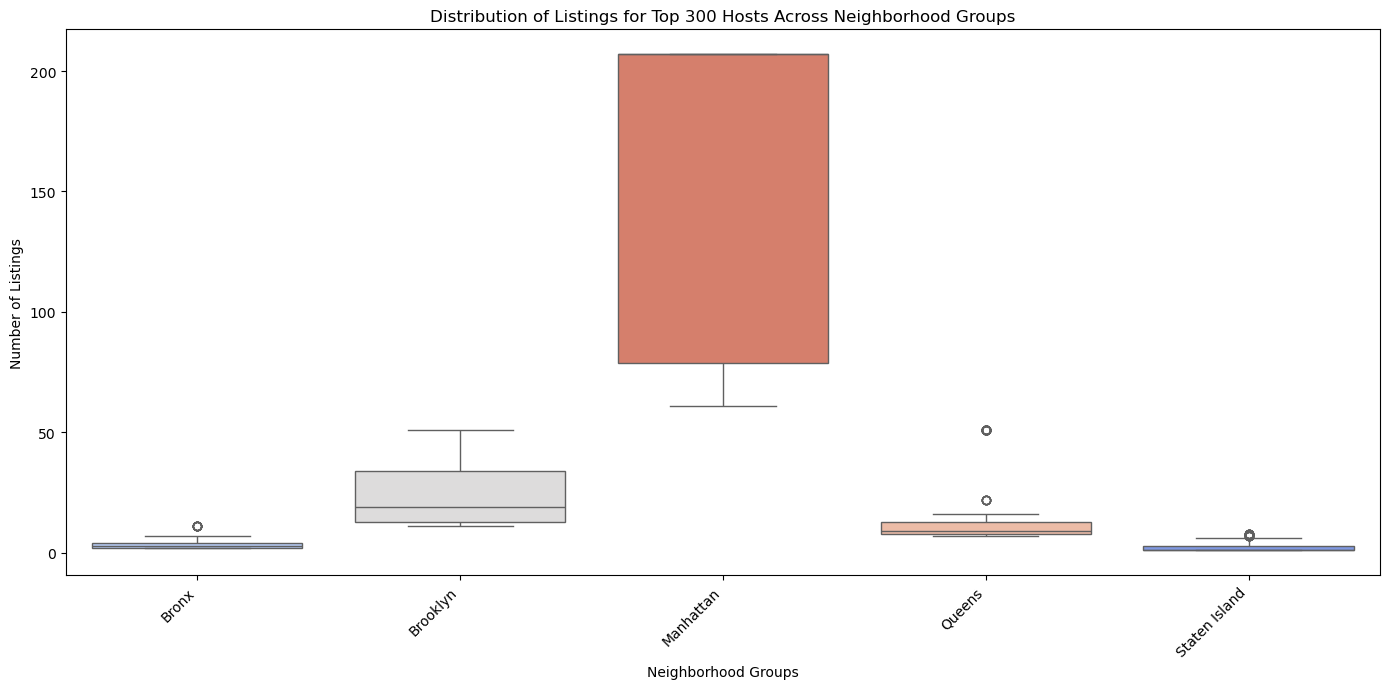

Here are the top 300 hosts busiest host in each neighborhood group based on the number of listings.


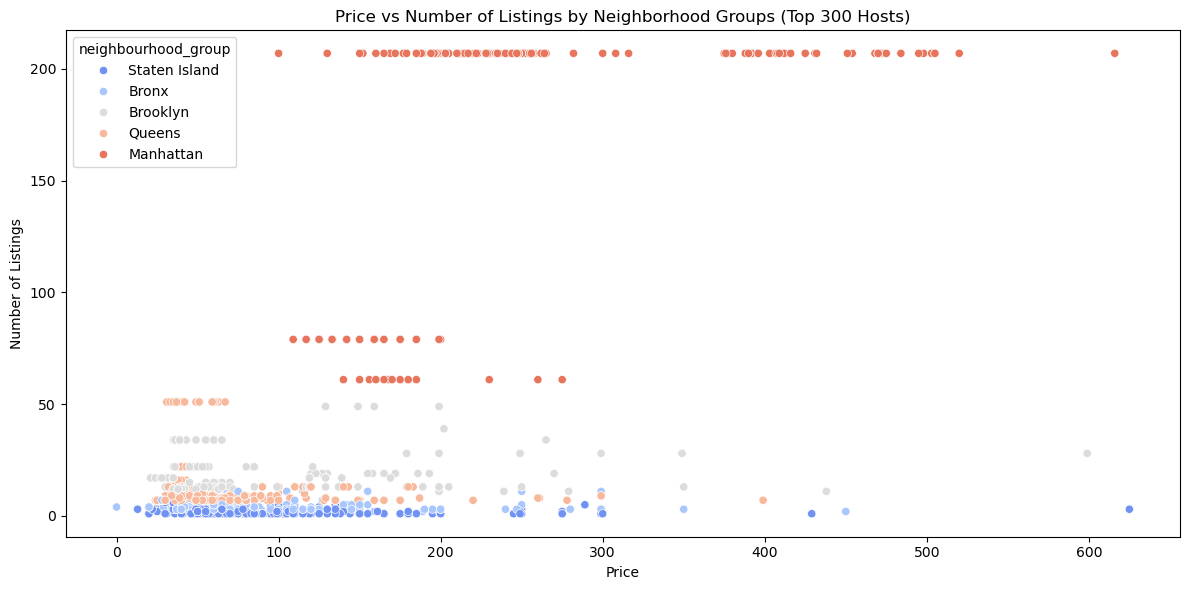

Overall finding for price: from all the neighborhood groups, Manhattan has the most expensive price, but it also contains reasonable pricing from $100-$200.



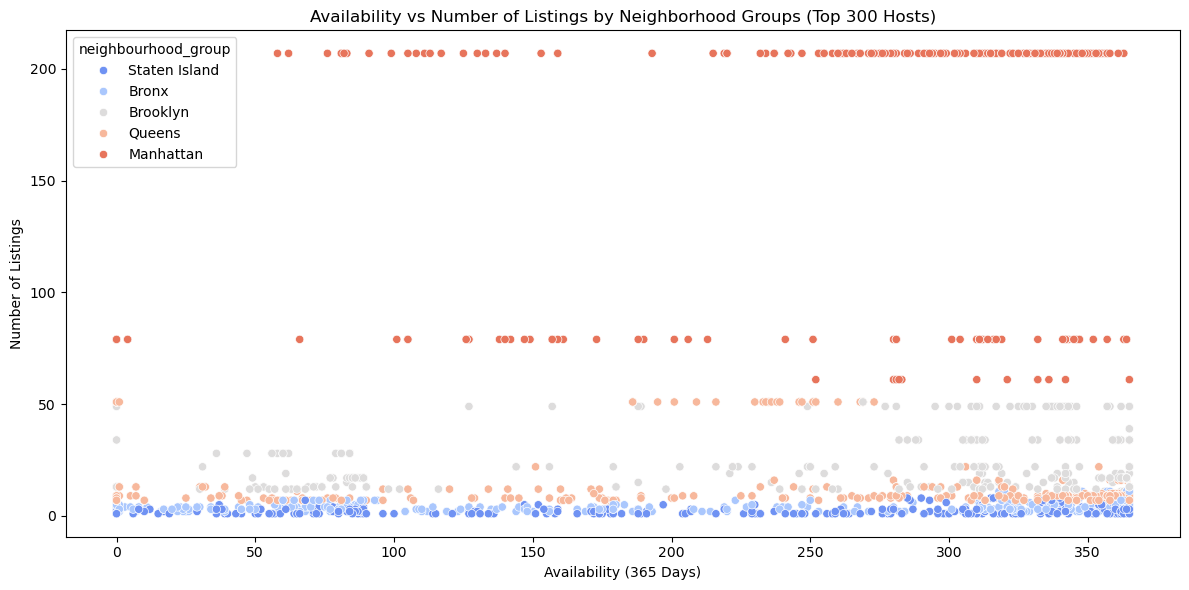

Overall finding for availability (365 Days): from all the neighborhood groups, Manhattan has the most days available (usually more than 250 days),
which is a good indicator that hosts in Manhattan are often available and likely have multiple listings to accommodate guests year-round.



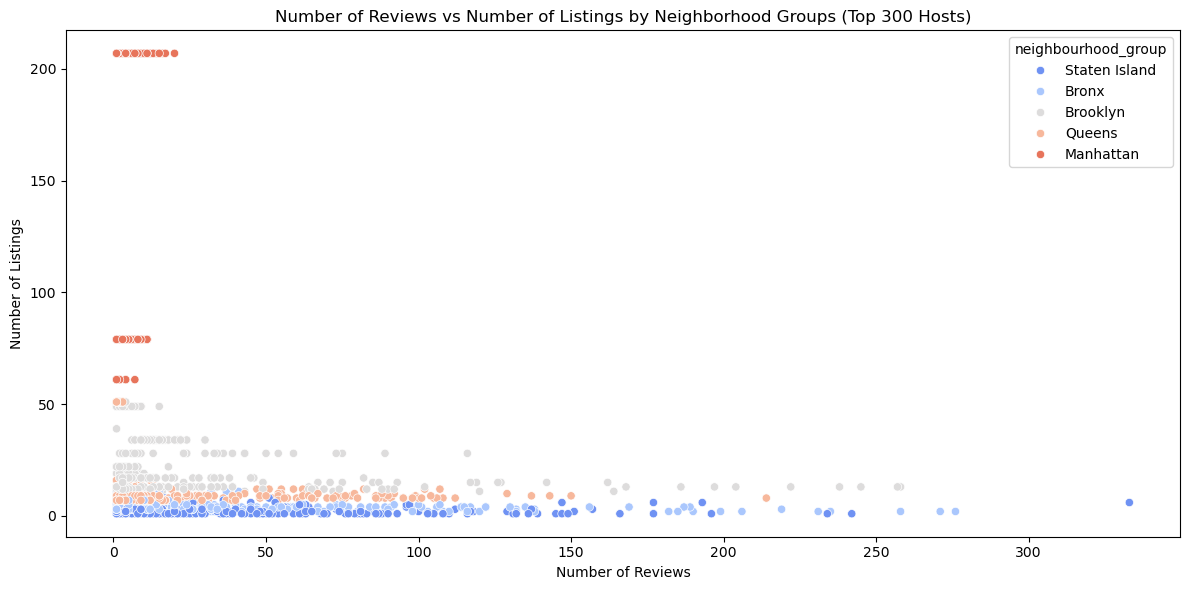

Overall finding for number of reviews: from all the neighborhood groups, Manhattan has the least reviews (mostly less than 25 reviews)
This suggests that hosts in Manhattan may have a higher turnover rate or a larger number of listings with fewer reviews per listing.

Overall finding for price, availability, and number of reviews for Manhattan:
 - Since Manhattan has a lot more hosts than any other neighborhood group, it is reasonable to say that people don't leave reviews for each host.
 - With a large number of hosts, availability is opened up to a larger range for people to pick from, leading to higher availability throughout the year.
 - It seems to be the case that Manhattan is the most expensive neighborhood group, with prices starting at $100 (within the 300 hosts). Due to the abundance of resources and attractions (such as stores, restaurants, and landmarks) in Manhattan, it is reasonable to say that the price is higher than in any other neighborhood group.
 - Manhattan likely 

In [255]:
#6. Find out which areas has the busiest (hosts with high number of listings) host? Are there any
#   reasons, why these hosts are the busiest, considers factors such as availability, price, review, etc.?
#   Bolster you reasoning with different plots and correlations. (10 Points)

'''
    Here are the top 300 hosts busiest host in each neighborhood group based on the number of listings.
'''
#Count the number of listings per host
df_before['listing_count'] = df_before['host_id'].map(df_before['host_id'].value_counts())

#Rank hosts within each neighborhood group and filter the top 300 per group
df_before['rank'] = df_before.groupby('neighbourhood_group')['listing_count'].rank(method='first', ascending=False)
top_hosts_data = df_before[df_before['rank'] <= 300].drop(columns=['rank'])

#Sort x-axis labels alphabetically
sorted_neighborhoods = sorted(top_hosts_data['neighbourhood_group'].unique())

#Plot the box-and-whisker plot for the top 300 hosts in each neighborhood group
plt.figure(figsize=(14, 7))
sns.boxplot(x='neighbourhood_group', 
            y='listing_count', 
            hue='neighbourhood_group',
            data=top_hosts_data, 
            palette='coolwarm',
            order=sorted_neighborhoods)

plt.xlabel("Neighborhood Groups")
plt.ylabel("Number of Listings")
plt.title("Distribution of Listings for Top 300 Hosts Across Neighborhood Groups")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Here are the top 300 hosts busiest host in each neighborhood group based on the number of listings.")

#Count the number of listings per host and rank hosts within each neighborhood group
df_before['listing_count'] = df_before['host_id'].map(df_before['host_id'].value_counts())

#Rank hosts within each neighborhood group and filter the top 300 per group
df_before['rank'] = df_before.groupby('neighbourhood_group')['listing_count'].rank(method='first', ascending=False)

#Filter the top 300 hosts per neighborhood group
top_hosts_data = df_before[df_before['rank'] <= 300].drop(columns=['rank'])

#Group the filtered data by neighborhood group and calculate summary statistics
neighborhood_summary = top_hosts_data.groupby('neighbourhood_group').agg(
    listing_count_mean=('listing_count', 'mean'),
    price_mean=('price', 'mean'),
    availability_mean=('availability_365', 'mean'),
    reviews_mean=('number_of_reviews', 'mean'),
    room_type_count=('room_type', 'nunique')
).reset_index()

#Scatter plots to explore relationships (Top 300 Hosts)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='price', y='listing_count', hue='neighbourhood_group', data=top_hosts_data, palette='coolwarm')
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.title("Price vs Number of Listings by Neighborhood Groups (Top 300 Hosts)")
plt.tight_layout()
plt.show()

print("Overall finding for price: from all the neighborhood groups, Manhattan has the most expensive price, but it also contains reasonable pricing from $100-$200.")
print()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='availability_365', y='listing_count', hue='neighbourhood_group', data=top_hosts_data, palette='coolwarm')
plt.xlabel("Availability (365 Days)")
plt.ylabel("Number of Listings")
plt.title("Availability vs Number of Listings by Neighborhood Groups (Top 300 Hosts)")
plt.tight_layout()
plt.show()

print("Overall finding for availability (365 Days): from all the neighborhood groups, Manhattan has the most days available (usually more than 250 days),")
print("which is a good indicator that hosts in Manhattan are often available and likely have multiple listings to accommodate guests year-round.")
print()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='number_of_reviews', y='listing_count', hue='neighbourhood_group', data=top_hosts_data, palette='coolwarm')
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Listings")
plt.title("Number of Reviews vs Number of Listings by Neighborhood Groups (Top 300 Hosts)")
plt.tight_layout()
plt.show()

print("Overall finding for number of reviews: from all the neighborhood groups, Manhattan has the least reviews (mostly less than 25 reviews)")
print("This suggests that hosts in Manhattan may have a higher turnover rate or a larger number of listings with fewer reviews per listing.")
print()

print("Overall finding for price, availability, and number of reviews for Manhattan:")
print(" - Since Manhattan has a lot more hosts than any other neighborhood group, it is reasonable to say that people don't leave reviews for each host.")
print(" - With a large number of hosts, availability is opened up to a larger range for people to pick from, leading to higher availability throughout the year.")
print(" - It seems to be the case that Manhattan is the most expensive neighborhood group, with prices starting at $100 (within the 300 hosts). Due to the abundance of resources and attractions (such as stores, restaurants, and landmarks) in Manhattan, it is reasonable to say that the price is higher than in any other neighborhood group.")
print(" - Manhattan likely has the highest number of listings compared to other neighborhood groups because it contains a larger concentration of hosts with multiple listings, as well as higher availability, allowing it to accommodate a broader range of guests throughout the year.")
print()

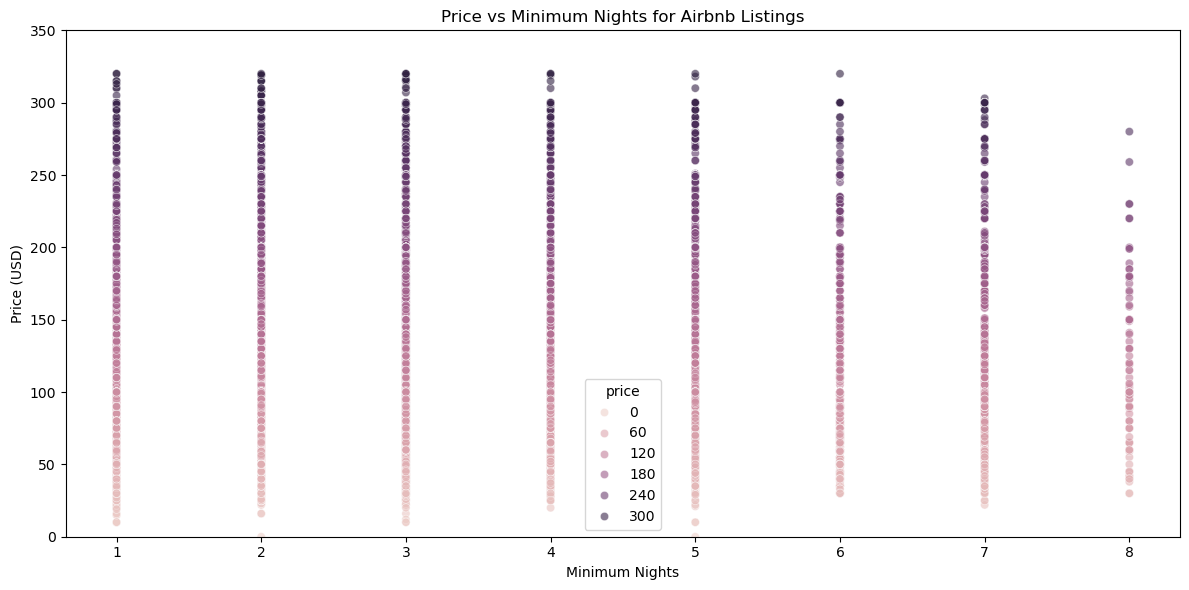

From this scatter plot it reveals that higher minimum nights often correlate with lower prices
This implies hosts may discount longer stays to attract guests.
Some low minimum nights (1–3 days) show extreme price ranges, indicating listings that charge premium rates for short stays (ex: luxury or last minute bookings), while others remain affordable.


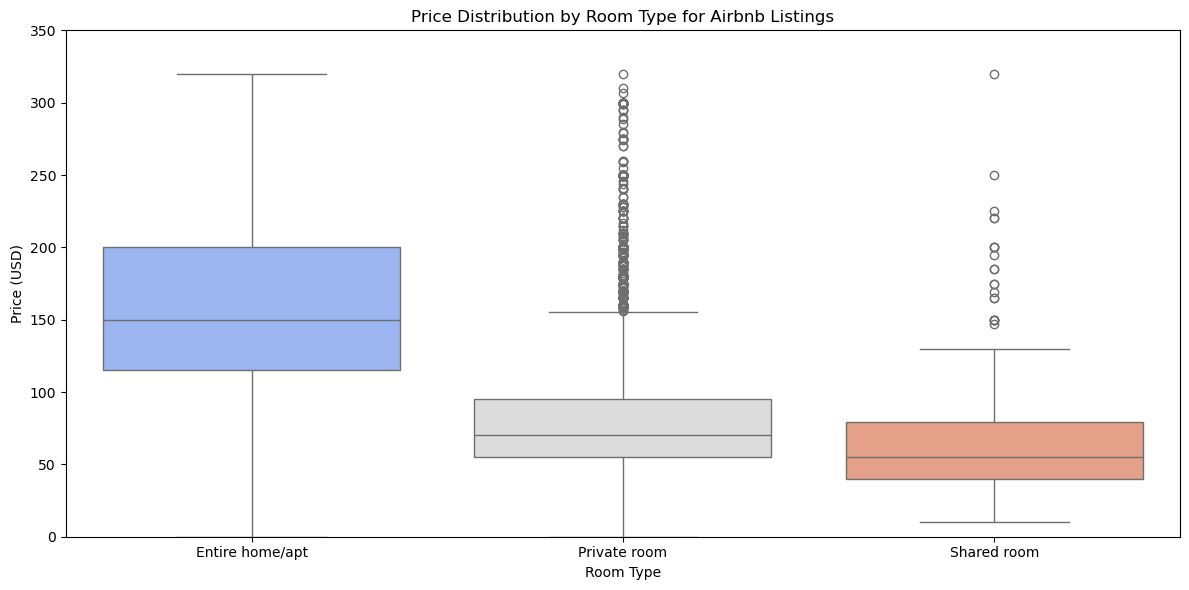

From this scatter plot it reveals that entire homes/apts have the highest median price, private rooms are mid-range, and shared rooms are the cheapest
This suggests that guests are willing to pay more for entire homes/apts, likely due to privacy and space especially with groups or families.


In [257]:
#7. Create two plots (at least one unique plot not used above) of your own using the dataset that you
# think reveals something very interesting. Explain what it is, and anything else you learned. (10
# Points)

#Plot Price vs Minimum Nights
plt.figure(figsize=(12, 6))
sns.scatterplot(x='minimum_nights', y='price', data=df_cleaned, hue='price', alpha=0.6)
plt.xlabel("Minimum Nights")
plt.ylabel("Price (USD)")
plt.title("Price vs Minimum Nights for Airbnb Listings")
plt.ylim(0, 350)
plt.tight_layout()
plt.show()

print("From this scatter plot it reveals that higher minimum nights often correlate with lower prices")
print("This implies hosts may discount longer stays to attract guests.")
print("Some low minimum nights (1–3 days) show extreme price ranges, indicating listings that charge premium rates for short stays (ex: luxury or last minute bookings), while others remain affordable.")

#Plot Price Distribution by Room Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df_cleaned, hue='room_type', palette='coolwarm')
plt.ylim(0, 350)
plt.xlabel("Room Type")
plt.ylabel("Price (USD)")
plt.title("Price Distribution by Room Type for Airbnb Listings")
plt.tight_layout()
plt.show()

print("From this scatter plot it reveals that entire homes/apts have the highest median price, private rooms are mid-range, and shared rooms are the cheapest")
print("This suggests that guests are willing to pay more for entire homes/apts, likely due to privacy and space especially with groups or families.")